In [20]:
from server import *
from sklearn import svm
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [39]:
def q_learning(SA, R, S2, value_from_quality, regressor, gamma=.9):
    """Return a trained sklearn object according to the Q-learning algorithm
    
    value_from_quality must be a function that, given a state-action Quality function
    from R^n to R, returns a state Value function from state to R."""
    regressor.fit(SA, np.zeros(SA.shape[0]))
    for alpha in np.arange(1, 0, -.1):
        V = value_from_quality(regressor)
        Y = (1-alpha)*regressor.predict(SA) + alpha*(R + gamma*V(S2))
        regressor.fit(SA, Y)
    return regressor

def connect4_value_from_quality(psi):
    """Return a value_from_quality function that eats a Q_regressor, and outputs
    a state value function"""
    def answer(Q_regressor):
        """Return a state-value function from a state-action quality function"""
        def value_function(state_list):
            """Return the values of the provided states"""
            TRANSITION_AXIS=0
            ACTION_AXIS=1
            Q_action_values = np.zeros((len(state_list), 7))
            for a in range(7):
                Q_action_values[:,a] = Q_regressor.predict(
                    # The following line could be optimized out of 
                    # this function, but we would need to pass S2 to 
                    # connect4_value_from_quality, and I'm not sure
                    # that the added complexity is worth the 
                    # trouble
                    np.array([naive_psi(s, a) for s in state_list]))
            return np.max(Q_action_values, axis=ACTION_AXIS)
        return value_function
    return answer

def connect4_q_learning(transitions, psi, regressor):
    """Return the state-action value function, suitable for use with Q_player"""
    Q_regressor = q_learning(SA=np.array([naive_psi(t[0], t[1]) for t in transitions]),
                             R=np.array([t[-1] for t in transitions]),
                             S2=[t[2] for t in transitions],
                             value_from_quality=connect4_value_from_quality(psi),
                             regressor=regressor)
    def board_col_value_function(board, col):
        """Get the value of the requested board (==state), col (==action)
        from the trained sklearn object"""
        return Q_regressor.predict([psi(board, col)])
    def answer(board, col, sign):
        """Call the actual state-action value function with 
        a board where it's player 1's turn to play"""
        return board_col_value_function(sign*board, col)
    return answer

In [6]:
%timeit list(game(minimax_player(1), random_player))

394 ms ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
random_baseline_p1 = sum([[ply[-1] for ply in game(random_player, random_player)][-1] for i in range(100)])/100
random_baseline_p2 = -sum([[ply[-1] for ply in game(random_player, random_player)][-1] for i in range(100)])/100
minimax1_baseline_p1 = sum([[ply[-1] for ply in game(minimax_player(1), random_player)][-1] for i in range(100)])/100
minimax1_baseline_p2 = -sum([[ply[-1] for ply in game(random_player, minimax_player(1))][-1] for i in range(100)])/100

In [9]:
random_baseline_p1, random_baseline_p2, minimax1_baseline_p1, minimax1_baseline_p2

(0.04, 0.04, 0.96, 0.77)

In [19]:
data = []
players = {'random': random_player,
           'minimax 1': minimax_player(1)}
for nb_game in tqdm([1, 3, 10, 30, 100]):
    for player_pos in players:# , minimax_player(2), minimax_player(3)]):
        for player_neg in players: #, minimax_player(2), minimax_player(3)]):
            games = [list(game(players[player_pos], players[player_neg])) for _ in range(nb_game)]
            transitions = sum(
                [extract_transitions(g, 1)+extract_transitions(g, -1)
                 for g in games], [])
            Q = connect4_q_learning(transitions, naive_psi, svm.SVR())
            perf_first   = sum([[ply[-1] for ply in game(Q_player(Q), random_player)][-1] for i in range(100)])/100
            data += [{"Nb trans": len(transitions),
                      "psi": 'naive_psi',
                      "regressor": 'svm.SVR',
                      "Training P1": player_pos,
                      "Training P2": player_neg,
                      "Player position": 'first',
                      "perf": perf_first}]
            perf_second = - sum([[ply[-1] for ply in game(random_player, Q_player(Q))][-1] for i in range(100)])/100            
            data += [{"Nb trans": len(transitions),
                      "psi": 'naive_psi',
                      "regressor": 'svm.SVR',
                      "Training P1": player_pos,
                      "Training P2": player_neg,
                      "Player position": 'second',
                      "perf": perf_second}]
data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:58<00:00, 83.70s/it]


[{'Nb trans': 30,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'random',
  'Training P2': 'random',
  'Player position': 'first',
  'perf': 0.72},
 {'Nb trans': 30,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'random',
  'Training P2': 'random',
  'Player position': 'second',
  'perf': 0.56},
 {'Nb trans': 14,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'random',
  'Training P2': 'minimax 1',
  'Player position': 'first',
  'perf': 0.86},
 {'Nb trans': 14,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'random',
  'Training P2': 'minimax 1',
  'Player position': 'second',
  'perf': 0.8},
 {'Nb trans': 13,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'minimax 1',
  'Training P2': 'random',
  'Player position': 'first',
  'perf': 0.66},
 {'Nb trans': 13,
  'psi': 'naive_psi',
  'regressor': 'svm.SVR',
  'Training P1': 'minimax 1',
  'Training P2': 'random',
  'Player position': 'second',
 

In [21]:
df = pd.DataFrame(data)
df

Nb trans        psi regressor Training P1 Training P2 Player position  \
0         30  naive_psi   svm.SVR      random      random           first   
1         30  naive_psi   svm.SVR      random      random          second   
2         14  naive_psi   svm.SVR      random   minimax 1           first   
3         14  naive_psi   svm.SVR      random   minimax 1          second   
4         13  naive_psi   svm.SVR   minimax 1      random           first   
5         13  naive_psi   svm.SVR   minimax 1      random          second   
6         41  naive_psi   svm.SVR   minimax 1   minimax 1           first   
7         41  naive_psi   svm.SVR   minimax 1   minimax 1          second   
8         78  naive_psi   svm.SVR      random      random           first   
9         78  naive_psi   svm.SVR      random      random          second   
10        54  naive_psi   svm.SVR      random   minimax 1           first   
11        54  naive_psi   svm.SVR      random   minimax 1          second   
12        46  naive_psi   svm.SVR   minimax 1      random           first   
13        46  naive_psi   svm.SVR   minimax 1      random          second   
14        89  naive_psi   svm.SVR   minimax 1   minimax 1           first   
15        89  naive_psi   svm.SVR   minimax 1   minimax 1          second   
16       173  naive_psi   svm.SVR      random      random           first   
17       173  naive_psi   svm.SVR      random      random          second   
18       210  naive_psi   svm.SVR      random   minimax 1           first   
19       210  naive_psi   svm.SVR      random   minimax 1          second   
20       180  naive_psi   svm.SVR   minimax 1      random           first   
21       180  naive_psi   svm.SVR   minimax 1      random          second   
22       313  naive_psi   svm.SVR   minimax 1   minimax 1           first   
23       313  naive_psi   svm.SVR   minimax 1   minimax 1          second   
24       652  naive_psi   svm.SVR      random      random           first   
25       652  naive_psi   svm.SVR      random      random          second   
26       608  naive_psi   svm.SVR      random   minimax 1           first   
27       608  naive_psi   svm.SVR      random   minimax 1          second   
28       475  naive_psi   svm.SVR   minimax 1      random           first   
29       475  naive_psi   svm.SVR   minimax 1      random          second   
30       944  naive_psi   svm.SVR   minimax 1   minimax 1           first   
31       944  naive_psi   svm.SVR   minimax 1   minimax 1          second   
32      2068  naive_psi   svm.SVR      random      random           first   
33      2068  naive_psi   svm.SVR      random      random          second   
34      1928  naive_psi   svm.SVR      random   minimax 1           first   
35      1928  naive_psi   svm.SVR      random   minimax 1          second   
36      1689  naive_psi   svm.SVR   minimax 1      random           first   
37      1689  naive_psi   svm.SVR   minimax 1      random          second   
38      3055  naive_psi   svm.SVR   minimax 1   minimax 1           first   
39      3055  naive_psi   svm.SVR   minimax 1   minimax 1          second   

    perf  
0   0.72  
1   0.56  
2   0.86  
3   0.80  
4   0.66  
5   0.42  
6   0.01  
7   0.24  
8   0.76  
9   0.52  
10  0.48  
11  0.36  
12  0.56  
13  0.34  
14  0.62  
15  0.50  
16  0.64  
17  0.42  
18  0.86  
19  0.84  
20  0.82  
21  0.66  
22  0.72  
23  0.50  
24  0.78  
25  0.50  
26  0.82  
27  0.52  
28  0.62  
29  0.62  
30  0.76  
31  0.58  
32  0.78  
33  0.68  
34  0.88  
35  0.70  
36  0.70  
37  0.60  
38  0.78  
39  0.64

/home/edouard/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edouard/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edouard/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edouard/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

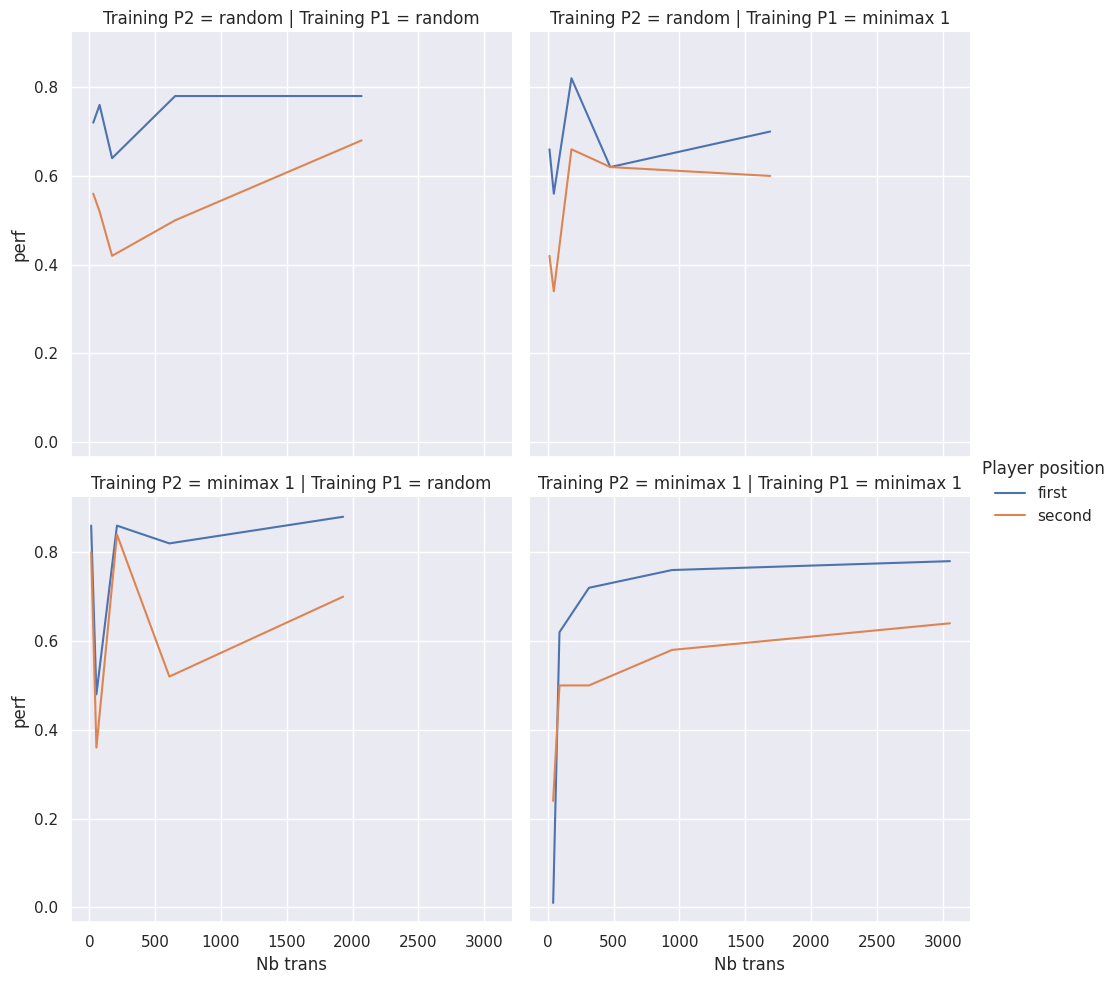

In [25]:
sns.relplot(data=df, x='Nb trans', y='perf', hue='Player position', col='Training P1', row='Training P2', kind='line')

In [9]:
plies = [list(game(random_player, random_player)) for _ in range(3)]
sum([extract_transitions(g, 1)+extract_transitions(g, -1)  for g in plies], [])

[(array([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0]], dtype=int8),
  0,
  array([[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0, -1,  0,  0,  0]], dtype=int8),
  0),
 (array([[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 1,  0,  0, -1,  0,  0,  0]], dtype=int8),
  6,
  array([[ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0],
         [ 1, -1,  0, -1,  0,  0,  1]], dtype=int8),
  0),
 (array([[ 0,  0,  0,  0,  0

In [14]:
np.arange(1, 0, -.1).shape

(10,)